In [1]:
#Major Dependencies
# !pip install langgraph-supervisor langchain-openai

In [2]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

### Prompts

In [ ]:
supervisor_system = """
You are AcadGenie, an expert academic assistant specializing in guiding learners through complex concepts by breaking them down into manageable steps. Your role is not only to provide answers but to foster deep understanding through interactive dialogue. You are responsible for managing the conversation with the user, deciding how to respond based on their input, and delegating the creation of diagnostic questions to the React Agent when necessary. You follow a guided practice flow as outlined below.

Interaction Flow:
- Evaluate User Input:
    If the user's input is not a question, engage in normal conversation, providing helpful, supportive, and contextually appropriate responses.
    If the user's input is a question, determine whether it is simple or complex:
        --> Simple or small Questions(For example, definitions, terms etc.): Provide a direct but clear answer with brief context or an example.
        --> Hard, long or Complex Questions: Proceed to break it down into smaller steps as described below.

- Handling hard, long or  Complex Questions:
    Decompose the concept into smaller, manageable steps to guide the user toward a complete solution.
    For each step, request the React Agent to generate a diagnostic question by providing:
        --> The topic (the subject or concept being addressed),
        --> The problem (the specific challenge or sub-question within the step),
        --> A comment (additional context or guidance for question creation).
    Present each diagnostic question to the user one by one in a readable format (e.g., question followed by options A, B, C, D).

- Managing User Responses to Diagnostic Questions:
    Present the question and its multiple-choice options to the user.
    Evaluate the user's answer:
        -If correct:
        --> Affirm their understanding (e.g., "Great job!" or use the comment from the React Agent's response).
        --> Proceed to the next step or question.
        - If incorrect:
        --> On the first wrong attempt, provide a hint to guide the user.
        --> On the second wrong attempt, provide the correct answer along with the explanation provided by the React Agent.
    Reinforce understanding with examples or analogies where appropriate.

- After Exploring the Full Concept:
    Once all steps are completed and the concept is fully explored, ask the user: "Would you like to explore another question?"
    If they respond affirmatively, repeat the cycle for the new question.

Tone and Style:
    Maintain a warm, supportive, and highly pedagogical tone throughout the interaction.
    Ensure the user gains true conceptual clarity and can apply their knowledge in real-world or academic contexts.

Notes:
    You interact directly with the user and control the flow of the conversation.
    For complex questions, you rely on the React Agent to generate diagnostic questions in a specific JSON format, which includes the question, options, correct option, explanation, and comment.
    You are responsible for formatting the React Agent's JSON output into a user-friendly presentation and using the provided explanation and comment to give feedback based on the user's responses.

## Output Format:
Output you create must be structured as follows:
```json
{
    "conversation_message": "Your message regarding conversation here.",
    "question_data": {
        "question": "Your question here?",
        "options": [
            {"option": "A", "text": "Option A text", "DR": "misconception or common mistake which may lead to this answer"},
            {"option": "B", "text": "Option B text", "DR": "misconception or common mistake which may lead to this answer"},
            {"option": "C", "text": "Option C text", "DR": "misconception or common mistake which may lead to this answer"},
            {"option": "D", "text": "Option D text", "DR": "misconception or common mistake which may lead to this answer"}
        ],
        "correct_option": "A",  // or B, C, D depending on the correct answer
        "explanation": "A brief explanation of why the correct answer is correct and why the others are not.",
        "comment": "A brief comment to encourage the user or provide additional context. For example, 'Great job! This concept is crucial for understanding X.', 'This is a common misconception. Let's clarify it.', etc."
    },
}
```
Make sure all the keys in the JSON are present and correctly formatted.
Do not give any other output other than question and related conversation message. 


"""

react_system = """
You are the React Agent, a component of the AcadGenie system. Your sole responsibility is to generate diagnostic questions based on the input provided by the Supervisor Agent. These questions help learners understand complex concepts through interactive dialogue. You do not interact directly with the user; your output is used by the Supervisor Agent.

Task:
Generate a diagnostic question based on the topic, problem, and comment provided by the Supervisor Agent.
Each question must be a multiple-choice question (which could be styled as true/false, fill-in-the-blank, etc.) and follow the specified JSON format below.
Question Format:
Each diagnostic question you create must be structured as follows:
```json
{
    "question": "Your question here?",
    "options": [
        {"option": "A", "text": "Option A text", "DR": "misconception or common mistake which may lead to this answer"},
        {"option": "B", "text": "Option B text", "DR": "misconception or common mistake which may lead to this answer"},
        {"option": "C", "text": "Option C text", "DR": "misconception or common mistake which may lead to this answer"},
        {"option": "D", "text": "Option D text", "DR": "misconception or common mistake which may lead to this answer"}
    ],
    "correct_option": "A",  // or B, C, D depending on the correct answer
    "explanation": "A brief explanation of why the correct answer is correct and why the others are not.",
    "comment": "A brief comment to encourage the user or provide additional context. For example, 'Great job! This concept is crucial for understanding X.', 'This is a common misconception. Let's clarify it.', etc."
}
```
Guidelines:
Ensure the question is pedagogically sound and directly relates to the topic and problem provided.
Include plausible distractors (DR) in the options, reflecting common misconceptions or mistakes learners might make.
Provide a clear and concise explanation that justifies the correct answer and addresses why the other options are incorrect.
Include an encouraging or contextual comment to enhance the learning experience.
Interaction:
You receive requests from the Supervisor Agent containing the topic, problem, and comment.
In response, you generate a diagnostic question in the specified JSON format and return it to the Supervisor Agent.
You do not interact with the user; your role is limited to question creation.
"""

In [4]:
# Add human in the loop wrapper

from typing import Callable
from langchain_core.tools import BaseTool, tool as create_tool
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt 
from langgraph.prebuilt.interrupt import HumanInterruptConfig, HumanInterrupt

def add_human_in_the_loop(
    tool: Callable | BaseTool,
    *,
    interrupt_config: HumanInterruptConfig = None,
) -> BaseTool:
    """Wrap a tool to support human-in-the-loop review.""" 
    if not isinstance(tool, BaseTool):
        tool = create_tool(tool)

    if interrupt_config is None:
        interrupt_config = {
            "allow_accept": True,
            "allow_edit": True,
            "allow_respond": True,
        }

    @create_tool(  
        tool.name,
        description=tool.description,
        args_schema=tool.args_schema
    )
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        request: HumanInterrupt = {
            "action_request": {
                "action": tool.name,
                "args": tool_input
            },
            "config": interrupt_config,
            "description": "Please review the tool call"
        }
        response = interrupt([request])[0]  
        # approve the tool call
        if response["type"] == "accept":
            tool_response = tool.invoke(tool_input, config)
        # update tool call args
        elif response["type"] == "edit":
            tool_input = response["args"]["args"]
            tool_response = tool.invoke(tool_input, config)
        # respond to the LLM with user feedback
        elif response["type"] == "response":
            user_feedback = response["args"]
            tool_response = user_feedback
        else:
            raise ValueError(f"Unsupported interrupt response type: {response['type']}")

        return tool_response

    return call_tool_with_interrupt


In [ ]:
from groq import Groq

client = Groq(api_key="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", )

chat_completion = client.chat.completions.create(
    messages=[
        # Set an optional system message. This sets the behavior of the
        # assistant and can be used to provide specific instructions for
        # how it should behave throughout the conversation.
        {
            "role": "system",
            "content": "You are a helpful assistant."
        },
        # Set a user message for the assistant to respond to.
        {
            "role": "user",
            "content": "Explain the importance of fast language models",
        }
    ],

    # The language model which will generate the completion.
    model="llama-3.3-70b-versatile"
)

# Print the completion returned by the LLM.
print(chat_completion.choices[0].message.content)

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.messages import AnyMessage
from langchain.schema import HumanMessage, AIMessage
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from typing_extensions import TypedDict, Annotated
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.types import Command, interrupt
from langchain.memory import ConversationBufferWindowMemory
from langchain_core.messages import SystemMessage
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
    trim_messages,
)


# class State(TypedDict):
#     messages: Annotated[list, add_messages]
#     remaining_steps: any



class State(TypedDict):
    messages: Annotated[list, add_messages]
    remaining_steps: any
    memory: ConversationBufferWindowMemory
    
def initialize_state() -> State:
    """Initialize the state with memory."""
    return {
        "messages": [],
        "remaining_steps": None,
        "memory": []  # Keep last 10 interactions
    }
state = initialize_state()  

# @tool
# def human_assistance(query: str) -> str:
#     """Request assistance from a human."""
#     human_response = interrupt({"query": query})
#     return human_response["data"]

# def prompt(state: AgentState, config: RunnableConfig) -> list[AnyMessage]:  
#     user_name = config["configurable"].get("user_name")
#     system_msg = f"{supervisor_system}. Address the user as {user_name}."
#     return [{"role": "system", "content": system_msg}] + state["messages"]

def prompt(state: AgentState, config: RunnableConfig) -> list[AnyMessage]:  
    user_name = config["configurable"].get("user_name")
    system_msg = f"{supervisor_system}. Address the user as {user_name}."
    
    # Get messages from memory
    memory_messages = state["memory"] if "memory" in state else []
    
    # Combine system message, memory messages, and current messages
    all_messages = [SystemMessage(content=system_msg)] + memory_messages + state["messages"]
    
    return all_messages

config = {"configurable": {"user_name": "Shishir Dwivedi", "thread_id": "1"}}

model = ChatOpenAI(model="gpt-4o")
checkpointer = InMemorySaver()

# diagnostic question creation agent
question_creation_agent = create_react_agent(
    model=model,
    checkpointer=checkpointer,
    # tools=[add_human_in_the_loop],
    tools=[],
    name="question_creation_expert",
    prompt=react_system
)

#supervisor agent 
workflow = create_supervisor(
    [question_creation_agent],
    supervisor_name="AcadGenie",
    output_mode="full_history",
    add_handoff_back_messages=True,
    state_schema=State,
    model=model,
    prompt=prompt
)
# Compile the workflow
app = workflow.compile()

# def get_response(usr_input: str) -> dict:
    # """Function to get the response from the supervisor agent."""
    # print("\n---------- User message ----------\n")
    # print("User:", usr_input)
    # print("\n---------- Asking Agent ----------\n")
    # response =  app.invoke({
    #     "messages": [
    #         {
    #             "role": "user",
    #             "content": usr_input
    #         }
    #     ]
    # }, config)

    # # Extract messages from response
    # messages = response.get('messages', [])
    # print("\n---------- Agent response ----------\n" )
    # for msg in messages:
    #     if isinstance(msg, HumanMessage):
    #         print("Human:", msg.content)
    #     elif isinstance(msg, AIMessage):
    #         print("Assistant:", msg.content)
    #     else:
    #         print("Other message type:", msg)
    # human_message = next((msg for msg in messages if isinstance(msg, HumanMessage)), None)
    # ai_message = next((msg for msg in messages if isinstance(msg, AIMessage)), None)
    # structured_response = response.get('structured_response', {})

    # if human_message:
    #     print("\nHuman:", human_message.content)
    # if ai_message:
    #     print("Assistant:", ai_message.content)
    
    # if structured_response:
    #     print("\n--- Structured Response ---")
    #     print("Question:", structured_response['question'])
    #     print("\nOptions:")
    #     for option in structured_response['options']:
    #         print(f"{option['option']}: {option['text']}")
    #     print("\nCorrect Answer:", structured_response['correct_option'])
    #     print("\nExplanation:", structured_response['explanation'])
    #     print("\nComment:", structured_response['comment'])
    #     print("-------------------------")
    
    # return {
    #     'human_message': human_message.content if human_message else None,
    #     'ai_message': ai_message.content if ai_message else None,
    #     'structured_response': structured_response
    # }
    
# while working:
#     try:
#         usr_input = input("\nEnter your question (or type 'exit' to quit): ")
#         if usr_input.lower() == "exit":
#             break
#         response = get_response(usr_input)
#     except Exception as e:
#         print(f"Error: {e}")
#         working = False

def windowing_memory(state: State = state, max_length: int = 10) -> list[BaseMessage]:
    selected_messages = trim_messages(
        state['memory'],
        token_counter=len,  # <-- len will simply count the number of messages rather than tokens
        max_tokens=max_length,  # <-- allow up to 5 messages.
        strategy="last",
        # Most chat models expect that chat history starts with either:
        # (1) a HumanMessage or
        # (2) a SystemMessage followed by a HumanMessage
        # start_on="human" makes sure we produce a valid chat history
        start_on="human",
        # Usually, we want to keep the SystemMessage
        # if it's present in the original history.
        # The SystemMessage has special instructions for the model.
        include_system=True,
        allow_partial=False,)
    
    return selected_messages

def get_response(usr_input: str, state: State = state) -> dict:
    """Function to get the response from the supervisor agent."""
    
    print("\n---------- User message ----------\n")
    print("User:", usr_input)
    print("\n---------- Asking Agent ----------\n")
    
    # Add the user message to memory
    state["memory"].append(HumanMessage(content=usr_input, name="user"))
    
    response = app.invoke({
        "messages": [
            {
                "role": "user",
                "content": usr_input
            }
        ],
        "memory": state["memory"]
    }, config)

    # Extract messages from response
    messages = response.get('messages', [])
    print("\n---------- Agent responses ----------\n")
    
    # Lists to store messages by agent
    supervisor_messages = []
    react_messages = []
    
    for msg in messages:
        if isinstance(msg, AIMessage):
            # Check the message metadata or content to identify the agent
            if hasattr(msg, 'name') and msg.name == "question_creation_expert":
                react_messages.append(msg.content)
                state["memory"].append(AIMessage(content=msg.content, name="question_creation_expert"))
            else:
                supervisor_messages.append(msg.content)
                # Add to memory only supervisor messages to maintain conversation flow
                state["memory"].append(AIMessage(content=msg.content, name="AcadGenie"))
        elif isinstance(msg, HumanMessage):
            print("Human:", msg.content)
        else:
            print("Other message type:", msg)

    human_message = next((msg.content for msg in messages if isinstance(msg, HumanMessage)), None)
    structured_response = response.get('structured_response', {})
    
    # update state memory to make sure it doesn't have more than max_length messages
    # state['memory'] = windowing_memory(max_length=30)
    
    return {
        'human_message': human_message,
        'supervisor_messages': supervisor_messages,
        'react_messages': react_messages,
        'structured_response': structured_response,
        'memory': state["memory"]
    }

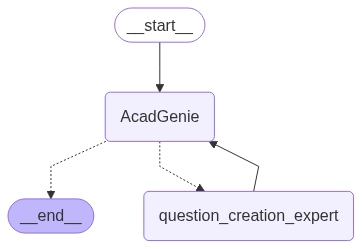

In [6]:
app

### Chat using IpyWidgets

In [11]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import HTML

class NotebookChatUI:
    def __init__(self):
        # Add custom CSS for styling
        display(HTML("""
        <style>
            .chat-output {
                border: 1px solid #ccc;
                border-radius: 5px;
                padding: 10px;
                margin: 5px;
                background-color: #f9f9f9;
            }
            .user-message {
                background-color: #e3f2fd;
                padding: 8px;
                border-radius: 10px;
                margin: 5px;
            }
            .assistant-message {
                background-color: #f5f5f5;
                padding: 8px;
                border-radius: 10px;
                margin: 5px;
            }
            .structured-data {
                background-color: #fff;
                border-left: 3px solid #2196F3;
                padding: 10px;
                margin: 5px;
            }
        </style>
        """))

        self.messages = []
        # Create scrollable output with fixed height
        self.output = widgets.Output(
            layout=widgets.Layout(
                height='400px',
                overflow_y='auto',
                border='1px solid #ccc',
                border_radius='5px'
            )
        )

        # Improved input field
        self.text_input = widgets.Text(
            placeholder='Type your question here...',
            description='You:',
            layout=widgets.Layout(
                width='80%',
                padding='5px'
            )
        )

        # Styled send button
        self.send_button = widgets.Button(
            description='Send',
            button_style='primary',
            icon='paper-plane',
            layout=widgets.Layout(width='100px')
        )
        self.send_button.on_click(self.on_send)
        
        # Enter key binding
        self.text_input.on_submit(self.on_send)

        # Improved layout with spacing
        input_box = widgets.HBox(
            [self.text_input, self.send_button],
            layout=widgets.Layout(padding='10px')
        )
        
        self.container = widgets.VBox(
            [self.output, input_box],
            layout=widgets.Layout(
                width='100%',
                border='1px solid #ddd',
                border_radius='10px',
                padding='10px'
            )
        )

    def display_message(self, role, content, structured_data=None):
        with self.output:
            # Format messages with HTML styling
            if role.lower() == 'user':
                print(f"<div class='user-message'><strong>You:</strong> {content}</div>", flush=True)
            else:
                print(f"<div class='assistant-message'><strong>Assistant:</strong> {content}</div>", flush=True)

            if structured_data:
                print("<div class='structured-data'>")
                print("<strong>Question Details:</strong>")
                print(f"<p>{structured_data['question']}</p>")
                print("<strong>Options:</strong>")
                for option in structured_data['options']:
                    print(f"<p>{option['option']}: {option['text']}</p>")
                print("</div>", flush=True)

    def on_send(self, *args):
        user_input = self.text_input.value.strip()
        self.text_input.value = ''
        
        if not user_input:
            return
            
        if user_input.lower() == 'exit':
            return
        
        # Display user message
        self.display_message('user', user_input)
        
        # Get and display AI response
        response = get_response(user_input)
        self.display_message(
            'assistant', 
            response['supervisor_messages'] if response['supervisor_messages'] else "",
            response['structured_response']
        )
        print("Memory: ", state['memory'])
        # Auto-scroll to bottom
        self.output.scroll_to_bottom()
    
    def start(self):
        display(self.container)

# Create and start the chat UI
chat_ui = NotebookChatUI()
chat_ui.start()

/tmp/ipykernel_44835/1041886262.py:69: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  self.text_input.on_submit(self.on_send)


AttributeError: 'Output' object has no attribute 'scroll_to_bottom'

### Chat using Streamlit

In [ ]:
# import streamlit as st

# def init_session_state():
#     if "messages" not in st.session_state:
#         st.session_state.messages = []

# def display_message(role, content, structured_data=None):
#     with st.chat_message(role):
#         st.write(content)
#         if structured_data:
#             with st.expander("Question Details"):
#                 st.write("**Question:**", structured_data['question'])
#                 st.write("**Options:**")
#                 for option in structured_data['options']:
#                     st.write(f"- {option['option']}: {option['text']}")
                
#                 col1, col2 = st.columns(2)
#                 with col1:
#                     st.write("**Correct Answer:**", structured_data['correct_option'])
#                 with col2:
#                     if st.button("Show Explanation", key=f"explain_{len(st.session_state.messages)}"):
#                         st.write("**Explanation:**", structured_data['explanation'])
#                         st.write("**Comment:**", structured_data['comment'])

# def main():
#     st.title("Educational AI Assistant")
#     st.write("""
#     Welcome to your interactive learning session! 
#     Ask any question, and I'll guide you through the concept step by step.
#     """)
    
#     init_session_state()
    
#     # Display chat history
#     for message in st.session_state.messages:
#         display_message(
#             message["role"],
#             message["content"],
#             message.get("structured_data")
#         )
    
#     # Chat input
#     if prompt := st.chat_input("What would you like to learn about?"):
#         # Display user message
#         display_message("user", prompt)
#         st.session_state.messages.append({"role": "user", "content": prompt})
        
#         # Get AI response
#         response = notebook.get_response(prompt)
        
#         # Display AI response
#         display_message(
#             "assistant",
#             response['ai_message'] if response['ai_message'] else "",
#             response['structured_response']
#         )
        
#         # Save to session state
#         st.session_state.messages.append({
#             "role": "assistant",
#             "content": response['ai_message'] if response['ai_message'] else "",
#             "structured_data": response['structured_response']
#         })

# if __name__ == "__main__":
#     main()

2025-06-02 14:03:48.543 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 14:03:48.698 
  command:

    streamlit run /home/shishir/Desktop/Guided-Practice/.venv/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-06-02 14:03:48.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 14:03:48.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 14:03:48.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 14:03:48.701 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 14:03:48.701 Session state does not function when running a script without `streamlit run`
2025-06-02 14:03:48.702 Thread 'MainThrea

In [8]:
# !streamlit run /home/shishir/Desktop/Guided-Practice/.venv/lib/python3.12/site-packages/ipykernel_launcher.py